In [1]:
# Parallel processing with Dask

[Dask](http://dask.pydata.org/) takes yet another approach to speeding up
Python computations. One of the main limitations of Python is that in
most cases, a single Python interpreter can only access a single thread
of computation at a time . This is because of the so-called Global
Interpreter Lock (or
[GIL](https://docs.python.org/3/glossary.html#term-global-interpreter-lock)).

And while there is a
[multiprocessing module](https://docs.python.org/3/library/multiprocessing.html)
in the Python standard library, it's use is cumbersome and often requires complicated
decisions. Dask simplifies this substantially, by making the code simpler, and
by making these decisions for you.


### Dask delayed computation:

Let's look at a simple example. The following are some very fast and simple 
calculations, and we add some `sleep` into them, to simulate a compute-intensive
task that takes some time to complete:

In [2]:
import time

def inc(x):
    time.sleep(1)
    return x + 1

def add(x, y):
    time.sleep(1)
    return x + y

Consider the calculation in the following cell. How long would it take to execute this?

In [3]:
x1 = inc(1)
x2 = inc(2)
z = add(x1, x2)

Notice that while `z` depends on both `x1` and `x2`, there is no
dependency between `x1` and `x2`. In principle, we could compute both of
them in parallel, but Python doesn't do that out of the box.

One way to convince Python to parallelize these is by telling Dask in
advance about the dependencies between different variables, and letting
it infer how to distribute the computations across threads:

In [4]:
from dask import delayed

x1 = delayed(inc)(1)
x2 = delayed(inc)(2)
z = delayed(add)(x1, x2)

Using the `delayed` function (a decorator!) tells Python not to perform
the computation until we're done setting up all the data dependencies.
Once we're ready to go we can compute one or more of the variables:

In [5]:
z.compute()

5

How much time did this take? Why?

Dask computes a task graph for this computation:

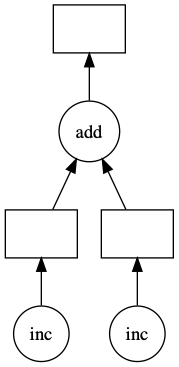

In [6]:
z.visualize()

Once this graph is computed, Dask can see that the two variables do not
depend on each other, and they can be executed in parallel. So, a
computation that would take 2 seconds serially is immediately sped up
n-fold (with n being the number of independent variables, here 2).


Dask has implementations of several commonly-used pythonic data-structures. In
particular, it implements a data structure that resembles the Numpy Array object
and another data structure that resembles the Pandas DataFrame. This lets us do
slightly more interesting things and leverage our knowledge of these tools.

Let's do something slightly more interesting (and neuro-related):

Let's say that we'd like to compute the tsnr over several runs of
fMRI data, for example, using the open-fMRI dataset ds000114:

In [7]:
import os.path as op
from glob import glob


fnames = glob(op.join(op.expanduser('~'), 'data/ds000114/sub-01/ses-test/func/*.nii.gz'))

This is a list with 5 different file-names, for the different runs during
this session.

One way to calculate the tsnr across is to loop over the
files, read in the data for each one of them, concatenate the data and then
compute the tsnr from the concatenated series:

In [8]:
fnames

['/Users/arokem/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-covertverbgeneration_bold.nii.gz',
 '/Users/arokem/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-overtwordrepetition_bold.nii.gz',
 '/Users/arokem/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz',
 '/Users/arokem/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-linebisection_bold.nii.gz',
 '/Users/arokem/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-overtverbgeneration_bold.nii.gz']

In [9]:
import numpy as np
import nibabel as nib

In [10]:
data = []
for fname in fnames:
    data.append(nib.load(fname).get_fdata())

data = np.concatenate(data, -1)
tsnr = data.mean(-1) / data.std(-1)

/Users/arokem/.virtualenvs/nh-curriculum/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


> #### Lazy loading in Nibabel
> Nibabel uses "lazy loading". That means that data are not read from file
> until when the nibabel `load` function is called on a file-name. Instead,
> Nibabel waits until we ask for the data, using the `get_data` method of
> The `Nifti1Image` class to read the data from file.

When we do that, most of the time is spent on reading the data from file.
As you can probably reason yourself, the individual items in the data
list have no dependency on each other, so they could be calculated in
parallel.

Because of nibabel's lazy-loading, we can instruct it to wait with the
call to `get_data`. We create a delayed function that we call
`delayed_get_data`:

In [11]:
delayed_get_data = delayed(nib.Nifti1Image.get_fdata)

Then, we use this function to create a list of items and delay each one
of the computations on this list:

In [12]:
data = []
for fname in fnames:
    data.append(delayed_get_data(nib.load(fname)))

data = delayed(np.concatenate)(data, -1)
tsnr = delayed(data.mean)(-1) / delayed(data.std)(-1)

Dask figures that out for you as well:

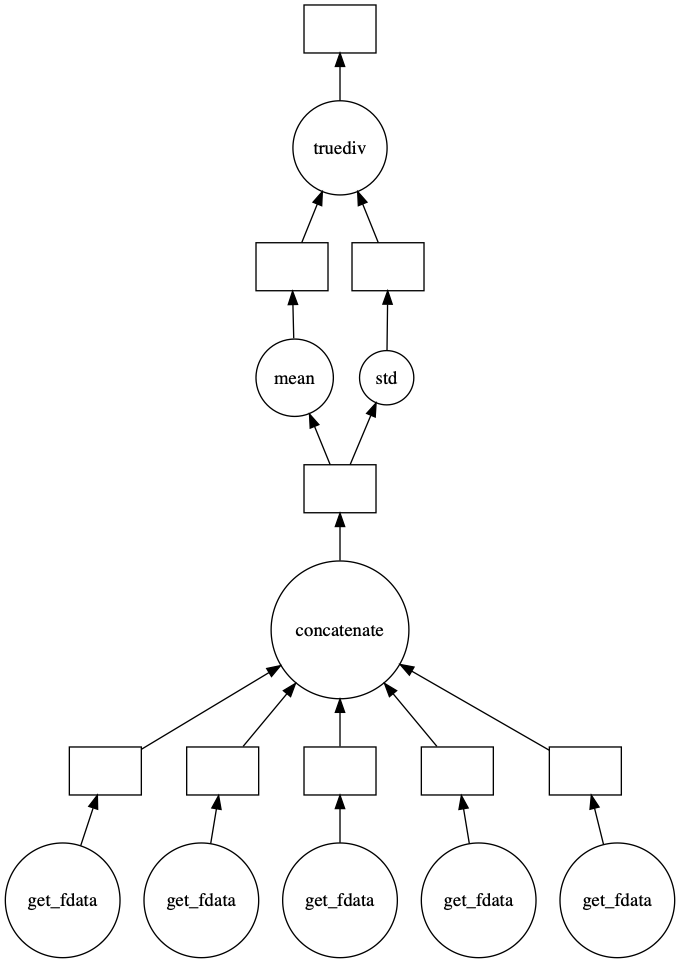

In [13]:
tsnr.visualize()

And indeed computing tsnr this way can give you an approximately 4-fold
speedup. This is because Dask allows the Python process to read several
of the files in parallel, and that is the performance bottle-neck here.

### Dask arrays

This is already quite useful, but wouldn't you rather just tell dask that
you are going to create some data and to treat it all as delayed until
you are ready to compute the tsnr?

This idea is implemented in the dask array interface. The idea here is that
you create something that provides all of the interfaces of a numpy array, but
all the computations are treated as delayed.

This is what it would look like for the tsnr example. Instead of
appending delayed calls to `get_data` into the array, we create a series
of dask arrays, with `delayed_get_data`. We do need to know both the shape
and data type of the arrays that will eventually be read, but

In [14]:
import dask.array as da

delayed_arrays = []
for fname in fnames:
    img = nib.load(fname)
    delayed_arrays.append(da.from_delayed(delayed_get_data(img),
                          img.shape,
                          img.get_data_dtype()))

    

If we examine these variables, we'll see something like this:

In [15]:
delayed_arrays

[dask.array<from-value, shape=(64, 64, 30, 173), dtype=int16, chunksize=(64, 64, 30, 173), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(64, 64, 30, 76), dtype=int16, chunksize=(64, 64, 30, 76), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(64, 64, 30, 184), dtype=int16, chunksize=(64, 64, 30, 184), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(64, 64, 30, 238), dtype=int16, chunksize=(64, 64, 30, 238), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(64, 64, 30, 88), dtype=int16, chunksize=(64, 64, 30, 88), chunktype=numpy.ndarray>]

These are notional arrays, that have not been materialized yet. The data
has not been read from memory yet, although dask already knows where it
would put them when they should be read.

We can use the `dask.array.concatenate` function:

In [16]:
arr = da.concatenate(delayed_arrays, -1)

And we can then use methods of the `dask.array` object to complete the
computation:

In [17]:
tsnr = arr.mean(-1) / arr.std(-1)

This looks exactly like the code we used for the numpy array!

Given more insight into what you want to do, dask is able to construct an
even more sophisticated task graph:

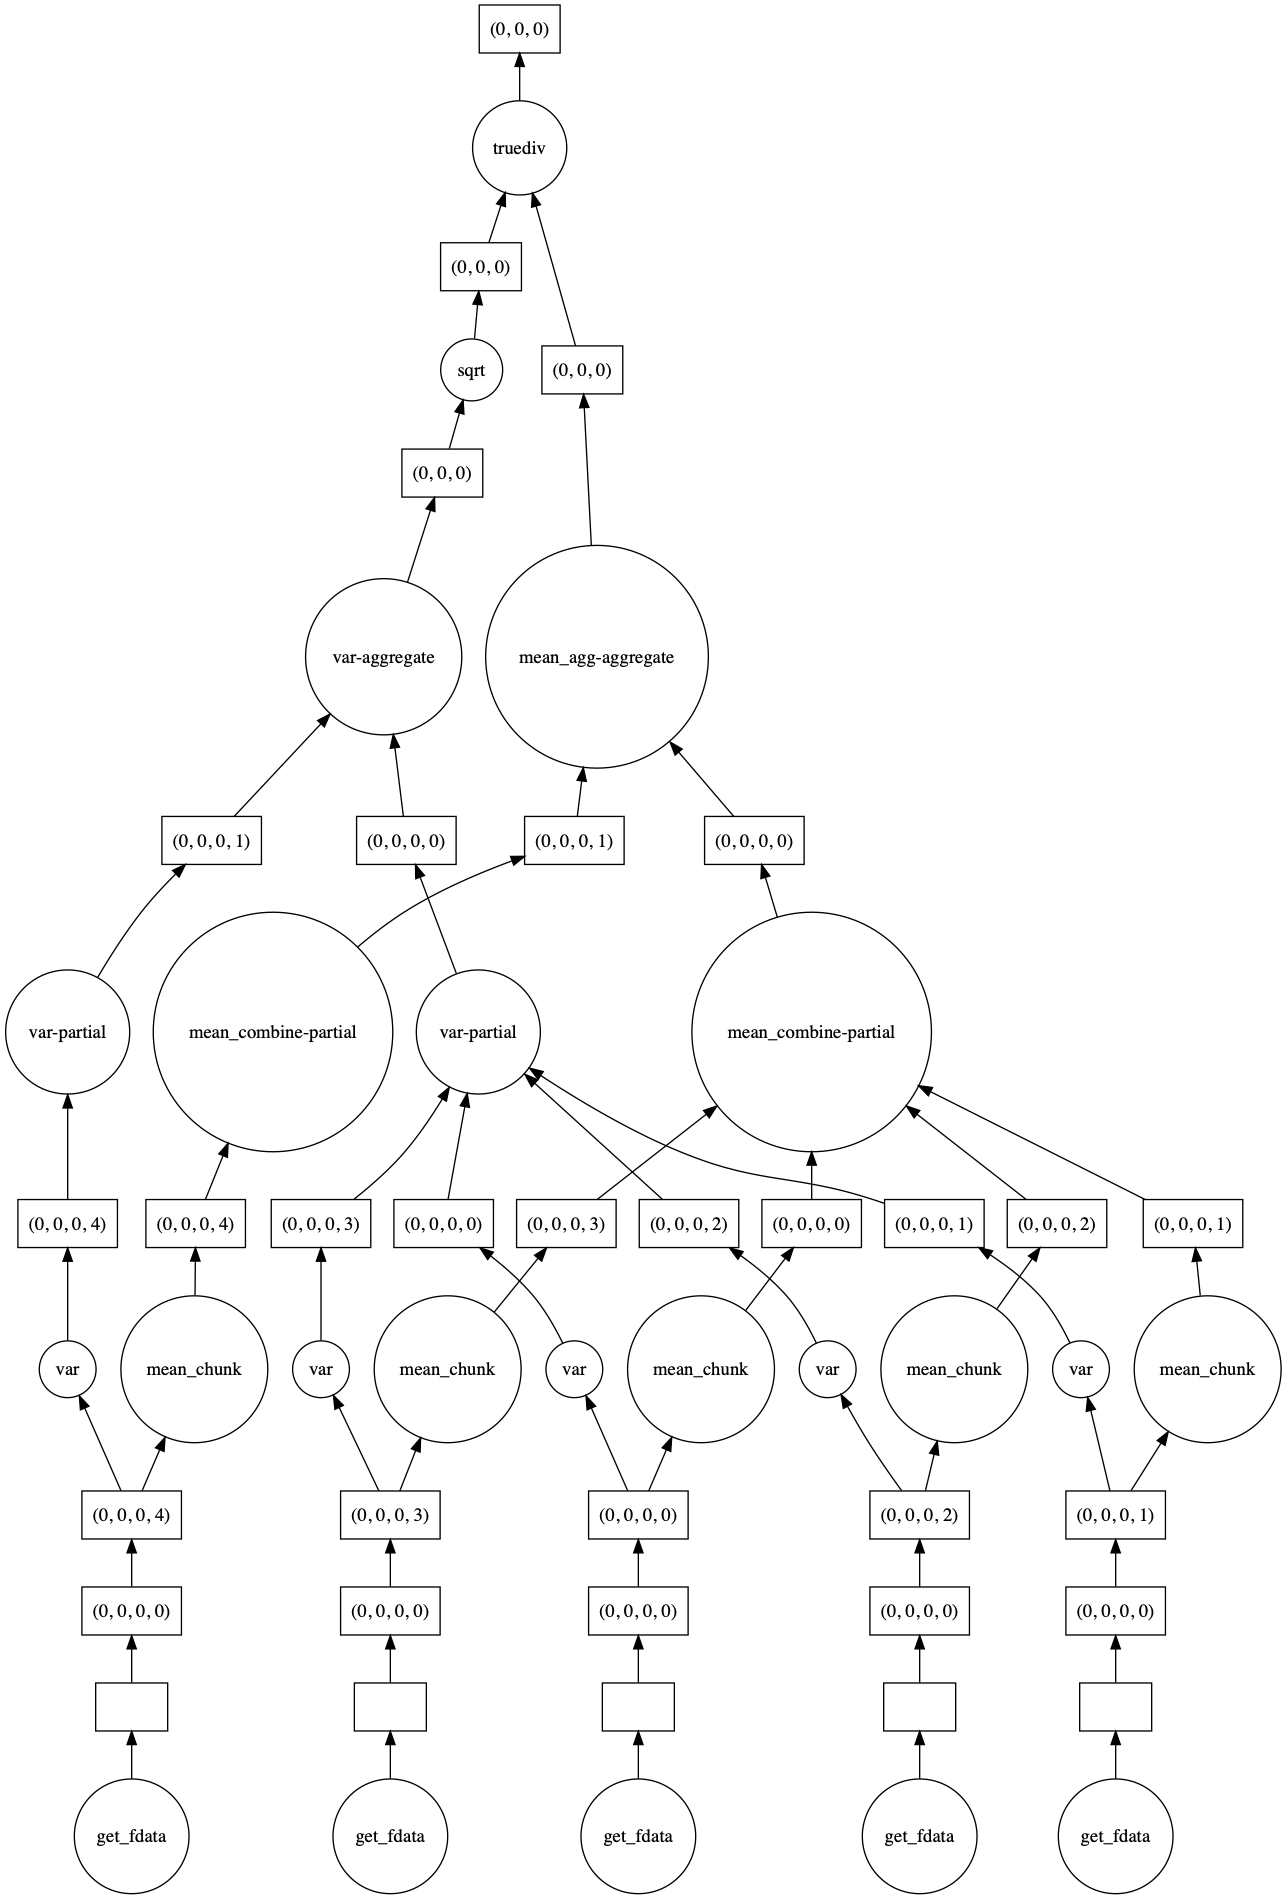

In [18]:
tsnr.visualize()

This looks really complicated, but notice that because dask has even more
insight into what we are trying to do, it can delay some things until
after aggregation. For example, the square root computation of the
standard deviation can be done once at the end, instead of on each array
separately.

And this leads to an approximately additional 2-fold speedup.

In [19]:
%%timeit
tsnr.compute()

/Users/arokem/.virtualenvs/nh-curriculum/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/arokem/.virtualenvs/nh-curriculum/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/arokem/.virtualenvs/nh-curriculum/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/arokem/.virtualenvs/nh-curriculum/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/arokem/.virtualenvs/nh-curriculum/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


413 ms ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/arokem/.virtualenvs/nh-curriculum/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


One of the main things to notice about the dask array is that because the
data is not read into memory it can represent very large datasets, and
schedule operations over these large datasets in a manner that makes the code
seem as though all the data is in memory.